# Train Siamese

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

Found 96 files for 24 unique classes
FOLDER PATH data/filter_aug/train


0epoch [00:00, ?epoch/s]

Epoch 1/75


2022-09-19 08:24:34.896210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 7s 1s/step - loss: 0.9882
Epoch 2/75
2/2 [==============================] - 3s 1s/step - loss: 0.9900
Epoch 3/75
2/2 [==============================] - 3s 1s/step - loss: 0.9711
Epoch 4/75
2/2 [==============================] - 3s 2s/step - loss: 0.9501
Epoch 5/75
2/2 [==============================] - 3s 2s/step - loss: 0.9212
Epoch 6/75
2/2 [==============================] - 3s 1s/step - loss: 0.8690
Epoch 7/75
2/2 [==============================] - 3s 2s/step - loss: 0.8209
Epoch 8/75
2/2 [==============================] - 3s 2s/step - loss: 0.7756
Epoch 9/75
2/2 [==============================] - 3s 2s/step - loss: 0.7096
Epoch 10/75
2/2 [==============================] - 3s 2s/step - loss: 0.6697
Epoch 11/75
2/2 [==============================] - 3s 2s/step - loss: 0.6309
Epoch 12/75
2/2 [==============================] - 3s 1s/step - loss: 0.5727
Epoch 13/75
2/2 [==============================] - 3s 1s/step - loss: 0.5628
Epoch 14/75
2/2 [==

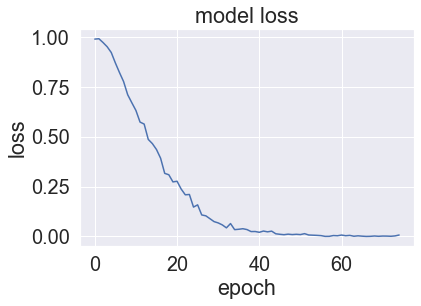


100%|████████████████████████████████████████| 96/96 [00:00<00:00, 20694.52it/s]

100%|███████████████████████████████████████████| 96/96 [00:02<00:00, 34.42it/s]
2022-09-19 08:28:31.776061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 352ms/step


In [207]:
# train_siamese.py

from datetime import datetime
import numpy
import tensorflow as tf
import tensorflow_addons as tfa
from absl import app
from tqdm.keras import TqdmCallback

from data.data_generator import DataGenerator
from model.siamese.config import cfg
from model.siamese.model_generator import create_model, base_models
import io
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import tensorflow_datasets as tfds

train_data_folder = "data/filter_aug/train"
test_data_folder = "data/filter_aug/test"

TRAINABLE = True

base_model = list(base_models.keys())[0]  # MobileNetV2, ResNet101V2, EfficientNetB5

WEIGHTS_DIR = "model/siamese/weights"
datatype = 'train'

#def main(_argv):

model = create_model(trainable=TRAINABLE, base_model=base_model)
#prefix = "block3c_add" # DLiske there is a default configured so I commented this out
prefix = '' #DLiske it's used in the filename so i had to keep it

try:
    tf.keras.utils.plot_model(
        model,
        to_file=f"assets/{base_model}_model_fig.png",
        show_shapes=True,
        expand_nested=True,
    )
except ImportError as e:
    print(f"Failed to plot keras model: {e}")

ds_generator = DataGenerator(
    file_ext=["png", "jpg"],
    folder_path=train_data_folder,
    exclude_aug=True,
    #step_size=4,
    step_size=1
)

# train_ds = ds_generator.get_dataset()

learning_rate = cfg.TRAIN.LEARNING_RATE

# optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) #DLiske the orig code had lr instead of learning_rate
loss_fun = tfa.losses.TripletSemiHardLoss() # DLiske comment only: The triplets are generated by TF
model.compile(loss=loss_fun, optimizer=optimizer, metrics=[])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    WEIGHTS_DIR + "/" + base_model + "/siam-{epoch}-"+str(learning_rate)+"-"+str(prefix)+"_{loss:.4f}.h5",
    monitor="loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)
stop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=cfg.TRAIN.PATIENCE, mode="min", restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.6, patience=5, min_lr=1e-6, verbose=1,
#                                                  mode="min")

# Define the Keras TensorBoard callback.
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


history = model.fit(
    ds_generator,
    #epochs=cfg.TRAIN.EPOCHS,
    epochs = 75,
    callbacks=[tensorboard_callback, checkpoint, TqdmCallback(verbose=0), stop],
    verbose=1
)

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

dataset = ds_generator.get_dataset()
results = model.predict(dataset)

# save pure results (embedding) and create meta mapping for each row (visualization files)
#np.savetxt(f"vecs-{FLAGS.datatype}-{base_model}.tsv", results, delimiter="\t")
np.savetxt(f"vecs-{datatype}-{base_model}.tsv", results, delimiter="\t")
#out_m = io.open(f"meta-{FLAGS.datatype}-{base_model}.tsv", "w", encoding="utf-8")
out_m = io.open(f"meta-{datatype}-{base_model}.tsv", "w")#, encoding="utf-8")
for img, labels in tfds.as_numpy(dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

# merge all embeddings per class
per_class = {}
idx = 0
for img, labels in tfds.as_numpy(dataset):
    for class_id in labels:
        if class_id not in per_class:
            per_class[class_id] = []
        per_class[class_id].append(results[idx])
        idx += 1

mean_values = None
labels = None
# calculate average value for each class
for class_id, values in per_class.items():
    #print("CLASS_ID", class_id)#, values)
    matrix = np.array(values)
    mean_val = np.mean(matrix, axis=0)
    if mean_values is None:
        mean_values = np.array([mean_val])
    else:
        mean_values = np.concatenate((mean_values, np.array([mean_val])), axis=0)
    if labels is None:
        labels = np.array([class_id], dtype='U20')
    else:
        labels = np.concatenate((labels, [class_id]), axis=0, dtype='U20')

np.save('/Users/debbieliske/Documents/CodingProjects/farm-animal-tracking-main/names', labels)

datatype = 'train'
# DLiske (I added b/c it seems like we shouldn't overwrite the avg embeddings if we're doing this on Test...)
if datatype == 'train': # DLiske
    # save avg embedding per class to be used as visualization and for further processing
    np.savetxt(f"vecs-conc-{base_model}.tsv", mean_values, delimiter="\t")
    #np.savetxt(f"meta-conc-{base_model}.tsv", labels, fmt="%i", delimiter="\t")
    np.savetxt(f"meta-conc-{base_model}.tsv", labels, fmt="%s", delimiter="\t") #D LISKE
    # np.savetxt(
    #     f"emb_space.csv", np.concatenate((mean_values, labels), axis=1), delimiter="\t"
    # )



In [202]:
labels

array(['Chinnar  6 Male', 'TVM 9 Male', 'Chinnar 10 Male',
       'Chinnar 9 Female', 'Chinnar 1 Male', 'TVM 7 Female',
       'Chinnar 2 Male', 'TVM 3 Female', 'Chinnar 17 Male', 'TVM 5 Male',
       'Chinnar 14 Female', 'Chinnar 4 Female', 'TVM 10 Male',
       'TVM 6 Female', 'Chinnar 15 Female', 'TVM 1 Male', 'TVM 4 Female',
       'TVM 8 Female', 'Chinnar 8 Male', 'Chinnar 16 Male',
       'Chinnar 11 Male', 'Chinnar 13 Female', 'TVM 2 Male',
       'Chinnar 5 Male'], dtype='<U20')

In [203]:
names

array(['Chinnar  6 Male', 'TVM 9 Male', 'Chinnar 10 Male',
       'Chinnar 9 Female', 'Chinnar 1 Male', 'TVM 7 Female',
       'Chinnar 2 Male', 'TVM 3 Female', 'Chinnar 17 Male', 'TVM 5 Male',
       'Chinnar 14 Female', 'Chinnar 4 Female', 'TVM 10 Male',
       'TVM 6 Female', 'Chinnar 15 Female', 'TVM 1 Male', 'TVM 4 Female',
       'TVM 8 Female', 'Chinnar 8 Male', 'Chinnar 16 Male',
       'Chinnar 11 Male', 'Chinnar 13 Female', 'TVM 2 Male',
       'Chinnar 5 Male'], dtype='<U20')

# Generate Siamese Embedded Space

In [25]:
# # generate_siamese_emb_space.py

# import io
# import pandas as pd
# import numpy as np
# import tensorflow_datasets as tfds
# from absl import app, flags
# from absl.flags import FLAGS

# from data.data_generator import DataGenerator
# from model.siamese.model_generator import create_model, base_models
# from model.siamese.config import cfg

# # flags.DEFINE_string(
# #     "weights",
# #     "siam-118-0.0001-1.0a_0.0633.h5",
# #     "weights name",
# # )

# # flags.DEFINE_string(
# #     "datatype",
# #     "train",
# #     "weights name",
# # )
# datatype = 'train' #D LISKE
# weights = 'siam-121-0.0001-_0.0000.h5' #D LISKE

# WEIGHTS_DIR = "model/siamese/weights"

# base_model = list(base_models.keys())[0]  # MobileNetV2, ResNet101V2, EfficientNetB5


# ### def main(_argv):
# #model = create_model(base_model=base_model)
# # if FLAGS.datatype != "train" and FLAGS.datatype != "test":
# #     FLAGS.datatype = "train"

# if datatype != "train" and datatype != "test":
#     datatype = "train"


# #model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{FLAGS.weights}")
# #model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{weights}")


# ds_generator = DataGenerator(
#     file_ext=["png", "jpg"],
#     #folder_path=f"data/filter_aug/{FLAGS.datatype}",
#     #folder_path=f"data/filter_aug/{datatype}",
#     folder_path=f"data/filter_aug/train",
#     exclude_aug=True,
#     step_size=1,
# )

# dataset = ds_generator.get_dataset()

# results = model.predict(dataset)

# # save pure results (embedding) and create meta mapping for each row (visualization files)
# #np.savetxt(f"vecs-{FLAGS.datatype}-{base_model}.tsv", results, delimiter="\t")
# np.savetxt(f"vecs-{datatype}-{base_model}.tsv", results, delimiter="\t")
# #out_m = io.open(f"meta-{FLAGS.datatype}-{base_model}.tsv", "w", encoding="utf-8")
# out_m = io.open(f"meta-{datatype}-{base_model}.tsv", "w")#, encoding="utf-8")
# for img, labels in tfds.as_numpy(dataset):
#     [out_m.write(str(x) + "\n") for x in labels]
# out_m.close()

# # merge all embeddings per class
# per_class = {}
# idx = 0
# for img, labels in tfds.as_numpy(dataset):
#     for class_id in labels:
#         if class_id not in per_class:
#             per_class[class_id] = []
#         per_class[class_id].append(results[idx])
#         idx += 1

# mean_values = None
# labels = None
# # calculate average value for each class
# for class_id, values in per_class.items():
#     #print("CLASS_ID", class_id)#, values)
#     matrix = np.array(values)
#     mean_val = np.mean(matrix, axis=0)
#     if mean_values is None:
#         mean_values = np.array([mean_val])
#     else:
#         mean_values = np.concatenate((mean_values, np.array([mean_val])), axis=0)
#     if labels is None:
#         labels = np.array([class_id], dtype='U20')
#     else:
#         labels = np.concatenate((labels, [class_id]), axis=0, dtype='U20')
              
# # DLiske (I added b/c it seems like we shouldn't overwrite the avg embeddings if we're doing this on Test...)
# if datatype == 'train': # DLiske
#     # save avg embedding per class to be used as visualization and for further processing
#     np.savetxt(f"vecs-conc-{base_model}.tsv", mean_values, delimiter="\t")
#     #np.savetxt(f"meta-conc-{base_model}.tsv", labels, fmt="%i", delimiter="\t")
#     np.savetxt(f"meta-conc-{base_model}.tsv", labels, fmt="%s", delimiter="\t") #D LISKE
#     # np.savetxt(
#     #     f"emb_space.csv", np.concatenate((mean_values, labels), axis=1), delimiter="\t"
#     # )



# Test Siamese

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 48 files for 24 unique classes
FOLDER PATH data/filter_aug/test



  0%|                                                    | 0/48 [00:00<?, ?it/s]2022-09-19 08:32:40.268522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.

100%|███████████████████████████████████████████| 48/48 [00:03<00:00, 14.68it/s]

(24, 24)


,precision,recall,f1-score,support
Chinnar 6 Male,1.00,1.00,1.00,2.00
Chinnar 1 Male,1.00,1.00,1.00,2.00
Chinnar 10 Male,1.00,0.50,0.67,2.00
Chinnar 11 Male,0.67,1.00,0.80,2.00
Chinnar 13 Female,1.00,1.00,1.00,2.00
Chinnar 14 Female,1.00,1.00,1.00,2.00
Chinnar 15 Female,1.00,1.00,1.00,2.00
Chinnar 16 Male,1.00,1.00,1.00,2.00
Chinnar 17 Male,1.00,1.00,1.00,2.00
Chinnar 2 Male,1.00,1.00,1.00,2.00


CM SHAPE (24, 24)


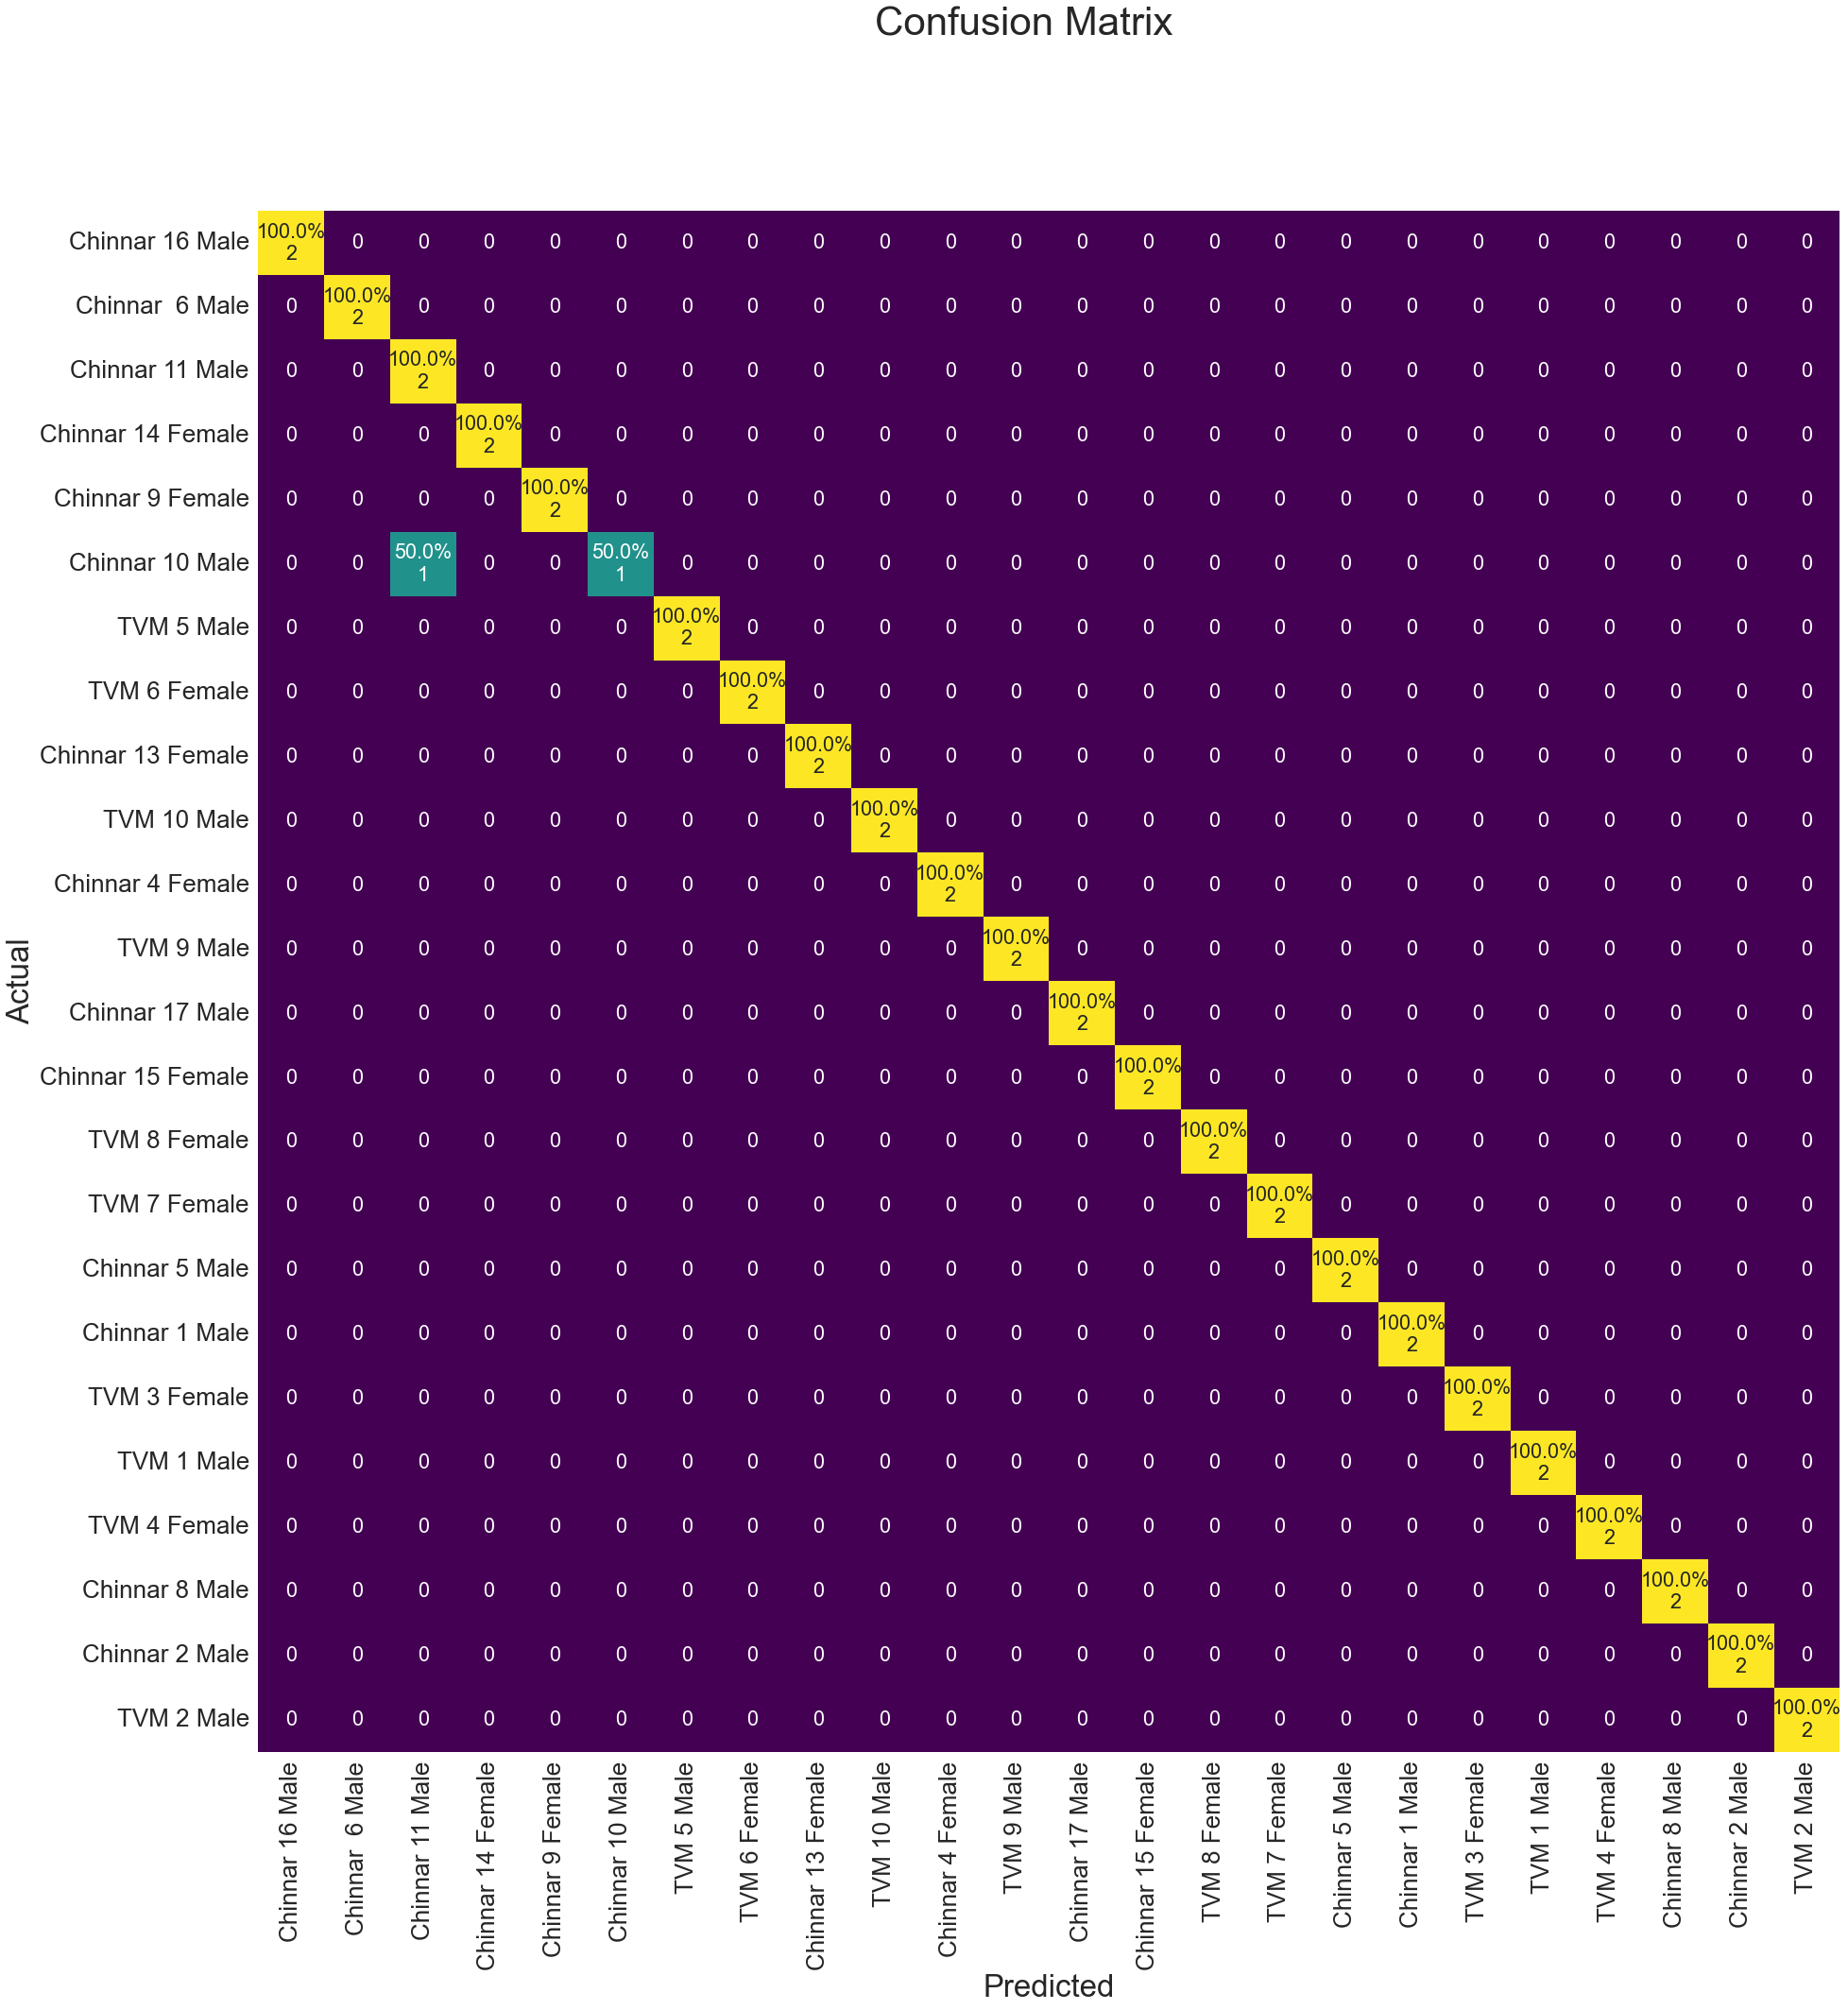

In [208]:
# test_siamese.py

%load_ext autoreload
%autoreload 2

import time

import numpy as np
import os
import datetime
from absl import app, flags
from absl.flags import FLAGS

from data.data_generator import DataGenerator
#from data.names import names
from helpers.score_processing import cm_analysis, classification_report_latex
from model.siamese.model_generator import create_model, base_models
from model.siamese.config import cfg
from data.siamese_evaluator import SiameseEvaluator

names = np.load('/Users/debbieliske/Documents/CodingProjects/farm-animal-tracking-main/names.npy')

# flags.DEFINE_string(
#     "weights",
#     "siam-147-0.001-block3c_add_0.2488.h5",
#     "weights name",
# )

# flags.DEFINE_string(
#     "datatype",
#     "train",
#     "weights name",
# )

# flags.DEFINE_string(
#     "vectors",
#     "model/siamese/vectors/vecs-conc-EfficientNetB5.tsv",
#     "path to vectors tsv",
# )

# flags.DEFINE_string(
#     "meta",
#     "model/siamese/vectors/meta-conc-EfficientNetB5.tsv",
#     "path to meta tsv",
# )

WEIGHTS_DIR = "model/siamese/weights"
#weights = 'siam-121-0.0001-_0.0000.h5' # DLiske
vectors = 'vecs-conc-MobileNetV2.tsv' # DLiske
meta = 'meta-conc-MobileNetV2.tsv'  # DLiske

#base_model = list(base_models.keys())[0]
# flags.DEFINE_string('target', './crop_images/5.jpg', 'path to input image')
# flags.DEFINE_string('source', './crop_images/1.jpg', 'path to input image')


def generate_test_dir(basemodel):
    test_dir = os.path.join(
        "experiments", "siamese", basemodel
    )

    if not os.path.isdir(test_dir):
        os.mkdir(test_dir)

    out_dir = os.path.join(
        test_dir, datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    )

    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)

    return out_dir


#def main(_argv):
out_dir = generate_test_dir(base_model)

#model = create_model(base_model=base_model)
#model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{FLAGS.weights}")
#model.load_weights(f"{WEIGHTS_DIR}/{base_model}/{weights}")
ds_generator = DataGenerator(
    file_ext=["png", "jpg"],
    folder_path=test_data_folder,
    exclude_aug=True,
    step_size=1,
)

# images = ds_generator.__getitem__(1)
# print(images[0].shape)
# print(images[1])


evaluator = SiameseEvaluator(model=model, dataset=ds_generator.org_images)
#evaluator.set_avg_vectors(FLAGS.vectors, FLAGS.meta)
evaluator.set_avg_vectors(vectors, meta)
conf_matrix, class_report, preds = evaluator.run_evaluation(compare_type="individual")
print(conf_matrix.shape)
display(pd.DataFrame(class_report).transpose().round(2))
cm_analysis(conf_matrix, names, filename=os.path.join(out_dir, f"conf_matrix_{base_model}.png"))
#classification_report_latex(class_report, filename=os.path.join(out_dir, f"class_report_{base_model}.txt"))

### DLiske: I added this b/c it seems we'd want to create embeddings for the test as well....?
# save pure results (embedding) and create meta mapping for each row (visualization files)
#np.savetxt(f"vecs-{FLAGS.datatype}-{base_model}.tsv", results, delimiter="\t")
# datatype = 'test'
# np.savetxt(f"vecs-{datatype}-{base_model}.tsv", results, delimiter="\t")
# #out_m = io.open(f"meta-{FLAGS.datatype}-{base_model}.tsv", "w", encoding="utf-8")
# out_m = io.open(f"meta-{datatype}-{base_model}.tsv", "w")#, encoding="utf-8")
# for img, labels in tfds.as_numpy(dataset):
#     [out_m.write(str(x) + "\n") for x in labels]
# out_m.close()


In [205]:
preds

[('TVM 2 Male',
  'TVM 2 Male',
  'data/filter_aug/test/TVM 2 Male/PXL_20220725_060656015.jpg'),
 ('TVM 2 Male',
  'TVM 2 Male',
  'data/filter_aug/test/TVM 2 Male/rot_PXL_20220725_060656015.jpg'),
 ('Chinnar 17 Male',
  'Chinnar 17 Male',
  'data/filter_aug/test/Chinnar 17 Male/PXL_20220723_082308255.MP.jpg'),
 ('Chinnar 17 Male',
  'Chinnar 17 Male',
  'data/filter_aug/test/Chinnar 17 Male/rot_PXL_20220723_082308255.MP.jpg'),
 ('TVM 10 Male',
  'TVM 10 Male',
  'data/filter_aug/test/TVM 10 Male/PXL_20220725_064601086.MP.jpg'),
 ('TVM 10 Male',
  'TVM 10 Male',
  'data/filter_aug/test/TVM 10 Male/rot_PXL_20220725_064601086.MP.jpg'),
 ('TVM 6 Female',
  'TVM 6 Female',
  'data/filter_aug/test/TVM 6 Female/PXL_20220725_061900174.jpg'),
 ('TVM 6 Female',
  'TVM 6 Female',
  'data/filter_aug/test/TVM 6 Female/rot_PXL_20220725_061900174.jpg'),
 ('Chinnar 2 Male',
  'Chinnar 2 Male',
  'data/filter_aug/test/Chinnar 2 Male/PXL_20220723_073547072.MP.jpg'),
 ('Chinnar 2 Male',
  'Chinnar 2 Mal

Actual Individual Chinnar 10 Male
Predicted Individual Chinnar 9 Female


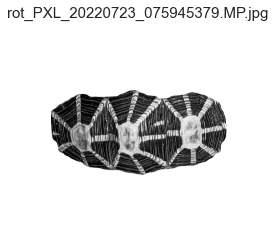

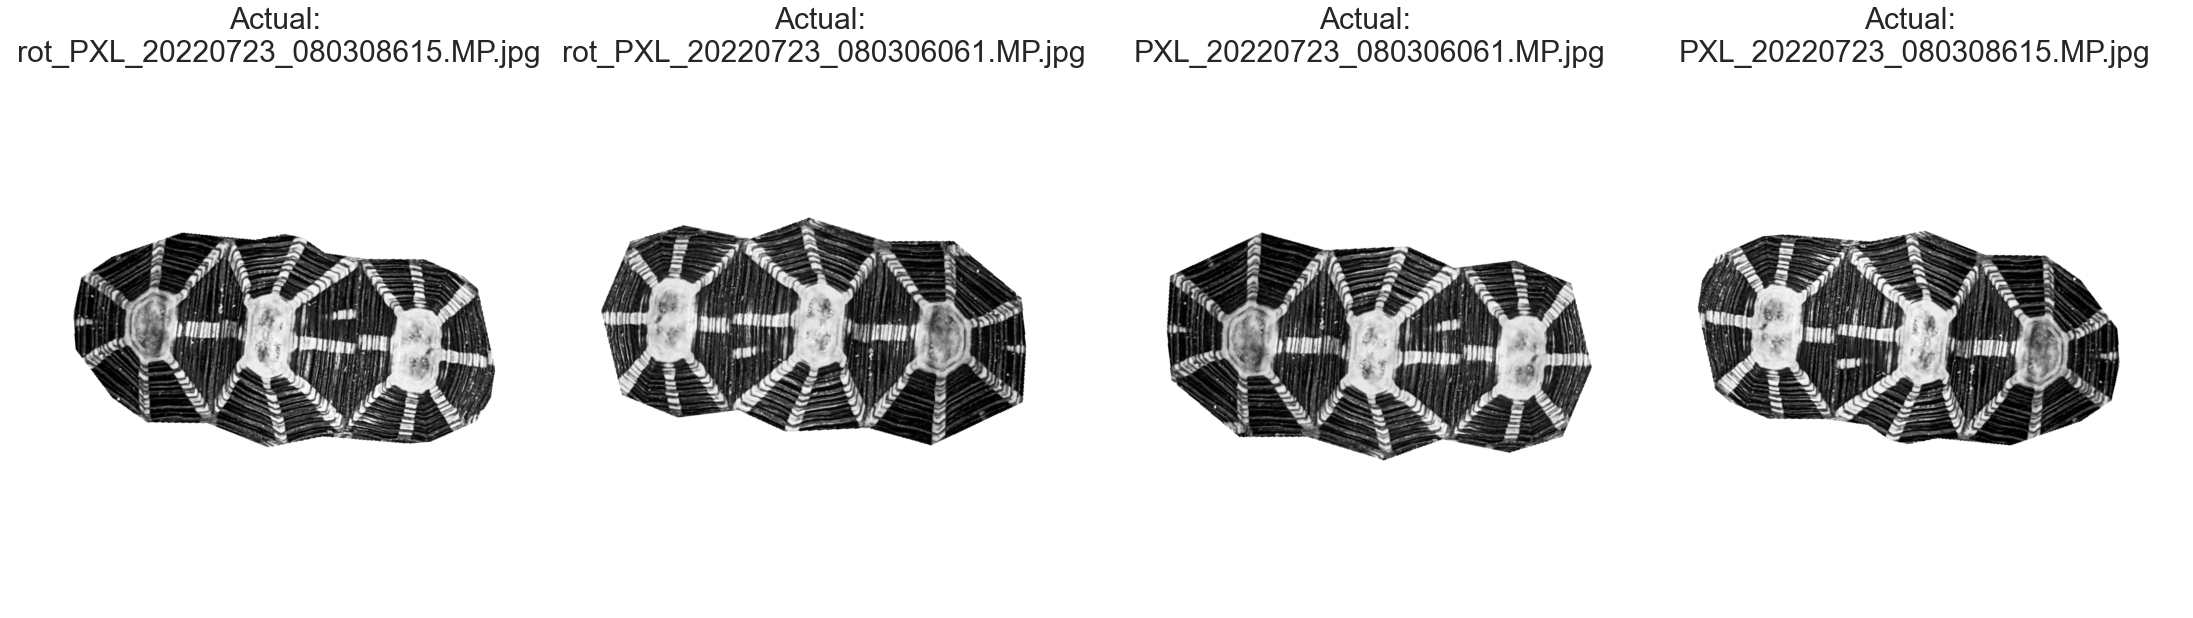

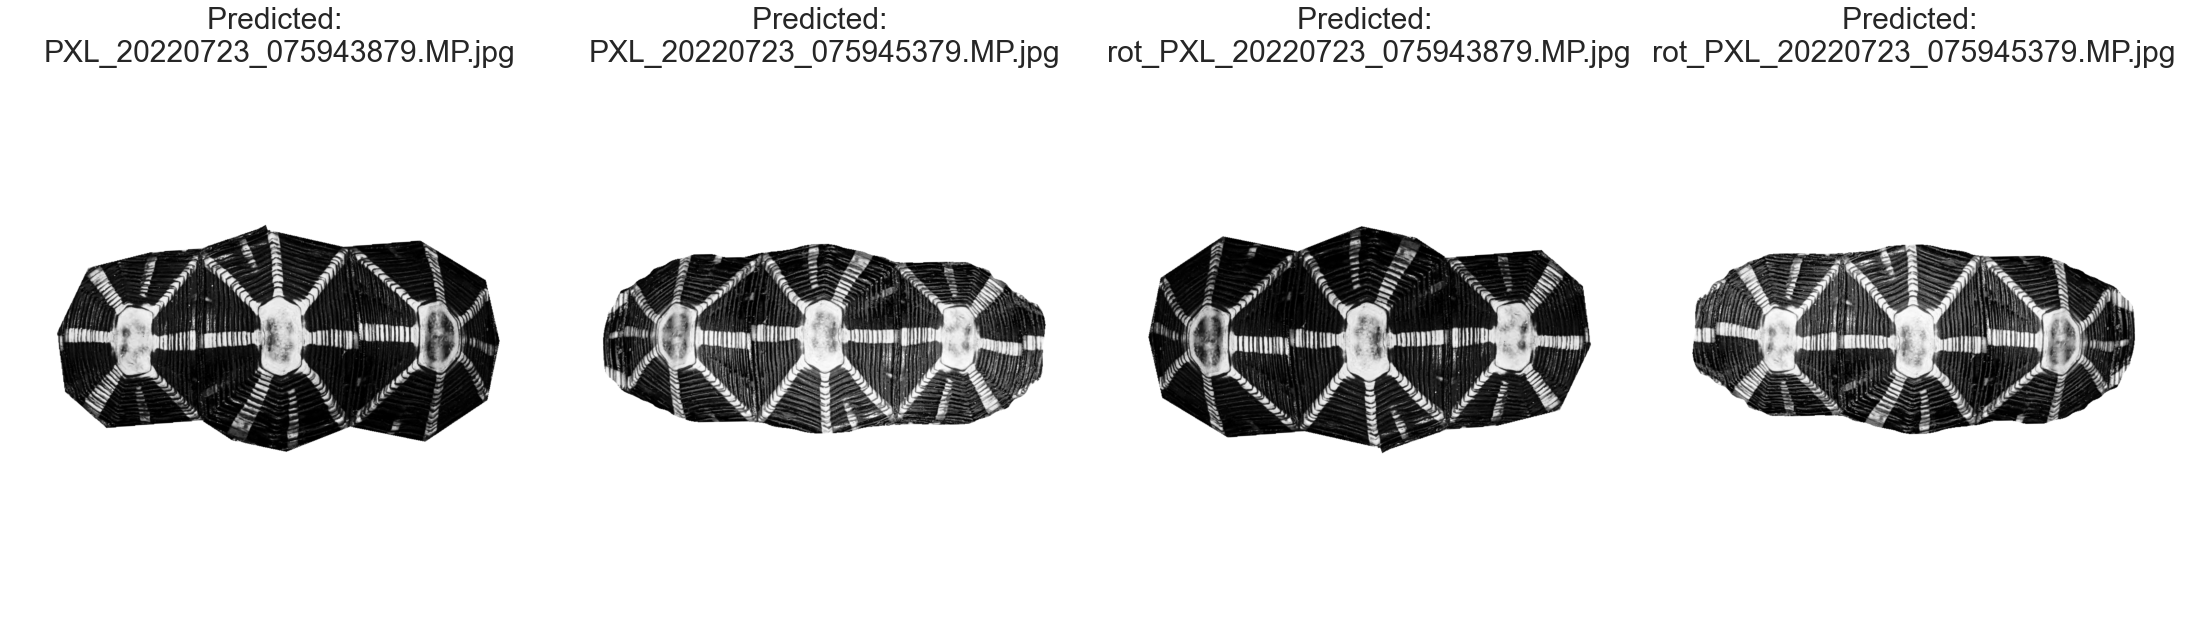

In [206]:
# from mpl_toolkits.axes_grid1 import ImageGrid
model_input_dir = '/Users/debbieliske/Documents/CodingProjects/farm-animal-tracking-main/model_input_dir/'
train_dir = '/Users/debbieliske/Documents/CodingProjects/farm-animal-tracking-main/data/filter_aug/train/'

actual_files = os.listdir(os.path.join(train_dir, actual_class))
predicted_files = os.listdir(os.path.join(train_dir, predicted_class))

for i in range(len(preds)):
    actual_class = preds[i][0]
    predicted_class = preds[i][1]
    if actual_class != predicted_class:
        actual_files = os.listdir(os.path.join(train_dir, actual_class))
        predicted_files = os.listdir(os.path.join(train_dir, predicted_class ))
        print("Actual Individual", actual_class)
        print("Predicted Individual", predicted_class)
        actual = plt.imread(preds[i][2])
        plt.imshow(actual, cmap='gray')
        plt.title(os.path.basename(filename), fontsize=15)
        plt.axis('off')
        im1 = plt.imread(os.path.join(train_dir, actual_class, actual_files[0]))
        im2 = plt.imread(os.path.join(train_dir, actual_class, actual_files[1]))
        im3 = plt.imread(os.path.join(train_dir, actual_class, actual_files[2]))
        im4 = plt.imread(os.path.join(train_dir, actual_class, actual_files[3]))
        im5 = plt.imread(os.path.join(train_dir, predicted_class, predicted_files[0]))
        im6 = plt.imread(os.path.join(train_dir, predicted_class, predicted_files[1]))
        im7 = plt.imread(os.path.join(train_dir, predicted_class, predicted_files[2]))
        im8 = plt.imread(os.path.join(train_dir, predicted_class, predicted_files[3]))

        fig = plt.figure(figsize=(40, 10))
        #fig.suptitle(title, fontsize=10)
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(1,4),  # creates 2x2 grid of axes
                         #axes_pad=0.001,  # pad between axes in inch.
                         )
        for ax, im, filename in zip(grid, [im1, im2, im3, im4], actual_files):
            # Iterating over the grid returns the Axes.
            ax.imshow(im, cmap='gray')
            ax.set_title("Actual: \n" + os.path.basename(filename), fontsize=30)
            ax.axis('off')

        fig = plt.figure(figsize=(40, 10))    
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1,4),  # creates 2x2 grid of axes
                     #axes_pad=0.001,  # pad between axes in inch.
                     )          
        for ax, im, filename in zip(grid, [im5, im6, im7, im8], predicted_files):
            # Iterating over the grid returns the Axes.
            ax.imshow(im, cmap='gray')
            ax.set_title("Predicted: \n" + os.path.basename(filename), fontsize=30)
            ax.axis('off')

        plt.show()
